In [1]:
# basic library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# ML model
import lightgbm as lgb


# Model Evaluation Metric
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error as mae

def MAE(y_true, predictions):
    y_true, predictions = y_true, predictions
    return np.mean(np.abs(y_true - predictions))

#Defining MAPE function
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [2]:
### data import need to change path if necessary

data0 = pd.read_csv("/Users/yvonne_zhu/Desktop/MSDS Capstone/Capstone_EDAV/RData/traffic_cleaned_forPython_k.csv", parse_dates=['day'])
data0.set_index('day', inplace=True)
data0.sort_index(inplace=True)

### data overview 
data0.head()

,CORE_LB_State,CORE_LB_City,CORE_LB_StoreType,CORE_LB_FlagShip,CORE_LB_SalesZone,CORE_LB_CommercialSign,CORE_VL_NbEntry,Holiday,weekday,year,month,Population,MHI,pop_density,mhi,per_capita
day,,,,,,,,,,,,,,,,
2016-01-01,AZ,SCOTTSDALE,Boutique,Standard,Mall,KIEHL'S,40,New Year's Day,Friday,2016,1,62.9,65913,1311.7,97409,70040
2016-01-01,CA,ARCADIA,Boutique,Standard,Mall,KIEHL'S,71,New Year's Day,Friday,2016,1,253.7,84097,5187.2,99588,47167
2016-01-01,CA,BERKELEY,Boutique,Standard,High Street,KIEHL'S,22,New Year's Day,Friday,2016,1,253.7,84097,11917.3,97834,56168
2016-01-01,CA,BREA,Boutique,Standard,Mall,KIEHL'S,52,New Year's Day,Friday,2016,1,253.7,84097,3889.3,108721,47945
2016-01-01,CA,CANOGA PARK,Boutique,Standard,Mall,KIEHL'S,25,New Year's Day,Friday,2016,1,253.7,84097,9942.0,84535,35589


In [3]:
# try to rolling window

def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(['CORE_LB_State', 'CORE_LB_City',
                                                                         'CORE_LB_StoreType',
                            'CORE_LB_FlagShip','CORE_LB_SalesZone'])['CORE_VL_NbEntry']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=7, win_type="triang").mean()) 
    return dataframe

In [4]:
def lookback(data, n_lookback):
    
    grouped = data.groupby(['CORE_LB_State', 'CORE_LB_City','CORE_LB_StoreType',
                            'CORE_LB_FlagShip','CORE_LB_SalesZone'])
    dfs = {key: group for key, group in grouped}
    df_list = []
    for key in dfs:
        df = dfs[key]
        for i in range(1,n_lookback+1):
            df[str(i)+'_day_lookback_NbEntry'] = df['CORE_VL_NbEntry'].shift(i)
        df_list.append(df)
        
    return pd.concat(df_list)

In [5]:
def lookback_on(data, n_lookback):
    grouped = data.groupby(['CORE_LB_State', 'CORE_LB_City','CORE_LB_StoreType',
                            'CORE_LB_FlagShip','CORE_LB_SalesZone'])
    dfs = {key: group for key, group in grouped}
    df_list = []
    for key in dfs:
        df = dfs[key]
        for i in n_lookback:
            df[str(i)+'_day_lookback_NbEntry'] = df['CORE_VL_NbEntry'].shift(i)
        df_list.append(df)
    return pd.concat(df_list)

In [6]:
# define function for splitting train test

def fun_split_train(train_ratio, 
                           val_ratio, 
                           test_ratio,
                           data,
                           target_col = 'CORE_VL_NbEntry'):
    
    train_size = int(train_ratio * len(data))
    val_size = int(val_ratio * len(data))
    test_size = len(data) - train_size - val_size
    
    train_data = data.iloc[:train_size]
    val_data = data.iloc[train_size:train_size + val_size]
    test_data = data.iloc[-test_size:]
    
    feature_cols = [col for col in data.columns if col != target_col]
    
    X_train, y_train = train_data[feature_cols], train_data[target_col]
    X_val, y_val = val_data[feature_cols], val_data[target_col]
    X_test, y_test = test_data[feature_cols], test_data[target_col]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [7]:
### Preprocessing 
data0['year'] = data0['year'].astype('category')
data0['month'] = data0['month'].astype('category')

### add window mean
data0 = roll_mean_features(data0, [7,14,30,365])

### One hot encoding on dataset
#data = pd.get_dummies(data0, dtype="bool")
#data = data.astype('int')

### One hot encoding on lagged data with n_lookback window
lagged_data = lookback(data0, n_lookback = 30)
lagged_data = pd.get_dummies(lagged_data, dtype="bool")
lagged_data = lagged_data.dropna()
lagged_data = lagged_data.astype('int')

### Lagged data only on certian important day
lagged2_data = lookback_on(data0, n_lookback = [1,6,7,27,5,21,28,12,14,4])
lagged2_data = pd.get_dummies(lagged2_data, dtype="bool")
lagged2_data = lagged2_data.dropna()
lagged2_data = lagged2_data.astype('int')

### To aviod "Do not support special JSON characters in feature name" error in LightGBM
import re
data = data0.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
lagged_data = lagged_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
lagged2_data = lagged2_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))


In [8]:
lagged_data

,CORE_VL_NbEntry,Population,MHI,pop_density,mhi,per_capita,sales_roll_mean_7,sales_roll_mean_14,sales_roll_mean_30,sales_roll_mean_365,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
day,,,,,,,,,,,,,,,,,,,,,
2016-01-31,36,62,65913,1311,97409,70040,25,27,28,30,...,0,0,0,0,0,0,0,0,0,0
2016-02-01,26,62,65913,1311,97409,70040,29,27,28,30,...,0,0,0,0,0,0,0,0,0,0
2016-02-02,22,62,65913,1311,97409,70040,32,27,28,30,...,0,0,0,0,0,0,0,0,0,0
2016-02-03,24,62,65913,1311,97409,70040,34,28,28,30,...,0,0,0,0,0,0,0,0,0,0
2016-02-04,26,62,65913,1311,97409,70040,32,28,28,30,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-14,26,115,82400,8791,105391,68836,33,28,32,31,...,0,0,0,0,0,1,0,0,0,0
2019-08-15,23,115,82400,8791,105391,68836,31,29,31,31,...,0,0,0,0,0,1,0,0,0,0
2019-08-16,32,115,82400,8791,105391,68836,29,29,31,31,...,0,0,0,0,0,1,0,0,0,0


In [9]:
lagged2_data.head()

,CORE_VL_NbEntry,Population,MHI,pop_density,mhi,per_capita,sales_roll_mean_7,sales_roll_mean_14,sales_roll_mean_30,sales_roll_mean_365,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
day,,,,,,,,,,,,,,,,,,,,,
2016-01-29,33,62,65913,1311,97409,70040,25,27,28,30,...,0,0,0,0,0,0,0,0,0,0
2016-01-30,47,62,65913,1311,97409,70040,24,27,28,30,...,0,0,0,0,0,0,0,0,0,0
2016-01-31,36,62,65913,1311,97409,70040,25,27,28,30,...,0,0,0,0,0,0,0,0,0,0
2016-02-01,26,62,65913,1311,97409,70040,29,27,28,30,...,0,0,0,0,0,0,0,0,0,0
2016-02-02,22,62,65913,1311,97409,70040,32,27,28,30,...,0,0,0,0,0,0,0,0,0,0


### Cyclical Features Encoding

### Sin and Cos 

- TODO: only on DAY to circle 365 days

In [10]:
from datetime import datetime, timedelta

# sin and cos transformations on both test and train set

# define function for sin and cos
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    data = data.drop([col], axis=1)
    
    return data


# transform on day 
def encode_day(data):
    
    data = data.reset_index()
    data['date'] = data['day']
    col = 'date'
    
    first_day = datetime(data[col].dt.year.unique()[0], 1, 1)
    #first_day = datetime("2016-01-01")
    
    # Compute the time difference between each date/time and the first date of the year
    day_diff = data[col] - first_day
    data[col] = day_diff.dt.days
    
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/365)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/365)
    data = data.drop([col], axis=1)
    
    #data = data.set_index('day', inplace=True)
    
    return data

data_trans = lagged_data.reset_index()
data_trans['date'] = data_trans['day']

data_trans['y'] = data_trans.date.dt.year
data_trans['m'] = data_trans.date.dt.month
data_trans['d'] = data_trans.date.dt.day

data_sincos = encode(data_trans, 'm', 12)
data_sincos = encode(data_trans, 'd', 31)
data_sincos.set_index('day', inplace=True)

# transform days per year into sin and cos
data_lagged_sincos = encode_day(lagged_data)
data_lagged_sincos = data_lagged_sincos.set_index('day')


# transform days for lagging on lagged2_data
data_lagged_sincos2 = encode_day(lagged2_data)
data_lagged_sincos2 = data_lagged_sincos2.set_index('day')


### light GBM model *** currently the winner
- with sin and cos transformation on 365 days, RMSE is slightly higher than without transformation
- include state and city
- 30 days lookback

In [11]:
X_train, y_train, X_val, y_val, X_test, y_test = fun_split_train(0.7, 0.2, 0.1, data_lagged_sincos)

# filling 0 with mean only on y_train (! after split) 
y_train = y_train.replace(0, y_train.mean())                                                                

### try taking np.log on target variable - RMSE 8.85
#log_y_train = np.log(y_train)

train_lgb = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
val_lgb = lgb.Dataset(X_val, label=y_val, reference=train_lgb, free_raw_data=False)


### hyperparameter  - tunning
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'max_depth': 8,
    'learning_rate': 0.055,
    'n_estimators': 1000,
    'reg_alpha': 0.4,  # L1 regularization term on weights
    'reg_lambda': 0.2}  # L2 regularization term on weights


### model fitting
model = lgb.train(params, train_lgb, valid_sets=[val_lgb], early_stopping_rounds=10)

/Users/yvonne_zhu/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/yvonne_zhu/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9252
[LightGBM] [Info] Number of data points in the train set: 60988, number of used features: 151
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 35.149660
[1]	valid_0's rmse: 43.3316
Training until validation scores don't improve for 10 rounds
[2]	valid_0's rmse: 41.4522
[3]	valid_0's rmse: 39.654
[4]	valid_0's rmse: 37.9622
[5]	valid_0's rmse: 36.3212

In [12]:
# Evaluate model on test data - light GBM
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = MAE(y_test, y_pred)
mape = MAPE(y_test, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test MAPE: {mape:.2f}")

Test RMSE: 7.77
Test MAE: 4.86
Test MAPE: 18.64


In [13]:
# investigate on feature importance
model.feature_importance()

array([ 69,  27,  65,  50,  35,  68,  64,  18, 108, 548, 144,  77,  58,
       103, 118, 267,  77,  42,  29,  17,  58,  44,  72,  42,  22,  27,
        29,  17,  35,  67,  36,  30,  26,  34,  40,  77,  82,  46,  33,
         0,  28,   0,   0,   0,   0,   0,   0,   7,   6,   0,   0,   0,
         0,   5,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   2,   0,  29,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   2,   7,   0,   0,   0,   0,   0,
        24,   0,   0,   0,   9,   0,   0,   0,   0,   7,   0,   0,   2,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         1,   0,   0,   0,   0,   0,   8,   0,   0,   2,   0,  36,  14,
         0,   0,  48,   1,  35,  45,   7,  18,   0, 122,  38,   0,  27,
        37,   0, 105, 109, 242,  33,  16,  40,  14,  14,  16,  13,  15,
        17,   1,   2,   2,  43,   0,   3,   0,   0,   3,  53,  7

In [14]:
X_test.columns

Index(['Population', 'MHI', 'pop_density', 'mhi', 'per_capita',
       'sales_roll_mean_7', 'sales_roll_mean_14', 'sales_roll_mean_30',
       'sales_roll_mean_365', '1_day_lookback_NbEntry',
       ...
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'date_sin', 'date_cos'],
      dtype='object', length=183)

In [15]:
import seaborn as sns

def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show(block=True)
    else:
        print(feat_imp.head(num))
    return feat_imp

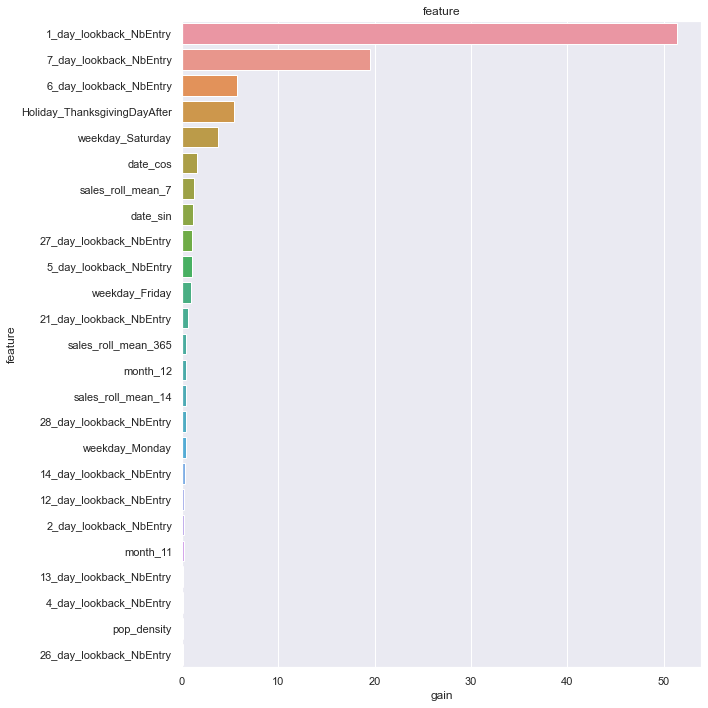

,feature,split,gain
9,1_day_lookback_NbEntry,548,51.310640
15,7_day_lookback_NbEntry,267,19.503142
14,6_day_lookback_NbEntry,118,5.705429
152,Holiday_ThanksgivingDayAfter,122,5.388125
160,weekday_Saturday,242,3.809852
...,...,...,...
82,CORE_LB_City_CHRISTIANA,0,0.000000
80,CORE_LB_City_CHESTNUTHILL,0,0.000000
78,CORE_LB_City_CANOGAPARK,0,0.000000
77,CORE_LB_City_BURLINGTON,0,0.000000


In [16]:
# if fitting on 1,6,7,27,5,21,28,12,14,4, RMSE is slightly higher 8.20
plot_lgb_importances(model,True, 20)

In [ ]:
def predict_with_lookback(X_test, lookback):
    y_pred = []
    for i in range(len(X_test)):
        # 
        if i%1000 == 0:
            print(i//1000)
            
        # 
        pred = model.predict(X_test.iloc[i])[0]
        # 
        y_pred.append(pred)
        
        # 
        store_location = X_test.columns[(X_test.iloc[i] == 1)].values
        store_location = [column for column in store_location if column.startswith("CORE_LB")]
        
        # 
        for j in lookback:
            if i+j >= len(X_test):
                break
            # 
            X_test.loc[(X_test.index == X_test.index[i+j]) & (X_test[store_location].eq(1).all(axis=1)),str(j)+"_day_lookback_NbEntry"] = pred
        
    return y_pred

y_pred2 = predict_with_lookback(X_test, range(1,31))
rmse = mean_squared_error(y_test, y_pred2, squared=False)
mae = MAE(y_test, y_pred)
mape = MAPE(y_test, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test MAPE: {mape:.2f}")

--- second stage model ----